In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree=20#多项式的最大阶数
n_train,n_test=100,100#训练和测试数据集的大小
true_w=np.zeros(max_degree)#分配大量的空间
true_w[0:4]=np.array([5,1.2,-3.4,5.6])
#用一个三阶多项式来生成训练和测试数据的标签，噪声项服从一个正态分布
features=np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
poly_features=np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:,i]/=math.gamma(i+1)
labels=np.dot(poly_features,true_w)
labels+=np.random.normal(scale=0.1,size=labels.shape)



In [3]:
true_w,features,poly_features,labels=[torch.tensor(x,dtype=torch.float32)for x in [true_w,features,poly_features,labels]]
features[:2],poly_features[:2,:],labels[:2]


(tensor([[-0.3573],
         [-0.1020]]),
 tensor([[ 1.0000e+00, -3.5734e-01,  6.3846e-02, -7.6049e-03,  6.7939e-04,
          -4.8554e-05,  2.8917e-06, -1.4762e-07,  6.5938e-09, -2.6180e-10,
           9.3553e-12, -3.0391e-13,  9.0500e-15, -2.4876e-16,  6.3495e-18,
          -1.5126e-19,  3.3783e-21, -7.1011e-23,  1.4097e-24, -2.6513e-26],
         [ 1.0000e+00, -1.0201e-01,  5.2035e-03, -1.7695e-04,  4.5128e-06,
          -9.2074e-08,  1.5655e-09, -2.2815e-11,  2.9093e-13, -3.2977e-15,
           3.3641e-17, -3.1199e-19,  2.6523e-21, -2.0813e-23,  1.5166e-25,
          -1.0315e-27,  6.5765e-30, -3.9465e-32,  2.2367e-34, -1.2009e-36]]),
 tensor([4.2497, 4.7609]))

In [4]:
def evaluate_loss(net,data_iter,loss):
    metric=d2l.Accumulator(2)
    for X,y in data_iter:
        out=net(X)
        y=y.reshape(out.shape)
        l=loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0]/metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))#单层线性回归网络
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.997577   1.2035246 -3.4060562  5.592431 ]]


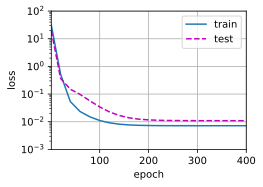

In [6]:
"""三阶多项式函数拟合(正常)"""
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])
#  使用三阶多项式函数，它与数据生成函数的阶数相同 效果较好

weight: [[3.0815005 4.6517916]]


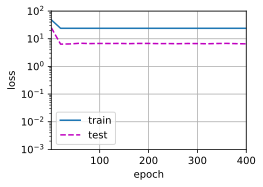

In [7]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])
"""线性函数拟合(欠拟合)"""

weight: [[ 5.0007715   1.2504983  -3.4236176   5.3673897   0.0407665   0.6639484
   0.43805525 -0.06562776 -0.05842865 -0.2220559  -0.12686427  0.16178152
  -0.15624684  0.06281447  0.05014169 -0.1610195   0.21042548 -0.0139493
   0.10749913  0.06714083]]


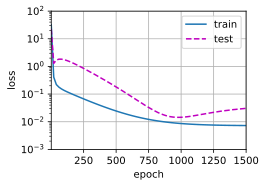

In [8]:
"""高阶多项式函数拟合(过拟合)"""
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)
# train和test的gap很大